In [1]:
import numpy as np
import pandas as pd
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import math
import cPickle
import os
import json
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import random
random.seed(0)
# Force matplotlib to not use any Xwindows backend.

In [2]:
# Read the data that Ajay labeled. Convert 1,000 to 1000
from IPython.core.debugger import Tracer
training_data_path = os.path.join(os.environ['DATA_DIR'], 'numerai_training_data.csv')
prediction_data_path = os.path.join(os.environ['DATA_DIR'], 'numerai_tournament_data.csv')
print("Loading data...")
# Load the data from the CSV files
training_data = pd.read_csv(training_data_path, header=0)
prediction_data = pd.read_csv(prediction_data_path, header=0)

Loading data...


In [3]:
# Some clean up. Replace #DIV/0! with 0
# I think 0 is a reasonable, non-biasing number because if, e.g. #Months is 0, a spend per month of 0 is reasonable
training_data.replace(to_replace='#DIV/0!',value='0',inplace=True)
training_data.fillna(0, inplace=True)
prediction_data.replace(to_replace='#DIV/0!',value='0',inplace=True)
prediction_data.fillna(0, inplace=True)
# Transform the loaded CSV data into numpy arrays
features = [f for f in list(training_data) if "feature" in f]
X = training_data[features]
Y = training_data["target"]
X_test = prediction_data[features]
Y_test = prediction_data["target"]
ids = prediction_data["id"]
X.sort_index(axis=1, inplace=True)
X_test.sort_index(axis=1, inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108405 entries, 0 to 108404
Data columns (total 21 columns):
feature1     108405 non-null float64
feature10    108405 non-null float64
feature11    108405 non-null float64
feature12    108405 non-null float64
feature13    108405 non-null float64
feature14    108405 non-null float64
feature15    108405 non-null float64
feature16    108405 non-null float64
feature17    108405 non-null float64
feature18    108405 non-null float64
feature19    108405 non-null float64
feature2     108405 non-null float64
feature20    108405 non-null float64
feature21    108405 non-null float64
feature3     108405 non-null float64
feature4     108405 non-null float64
feature5     108405 non-null float64
feature6     108405 non-null float64
feature7     108405 non-null float64
feature8     108405 non-null float64
feature9     108405 non-null float64
dtypes: float64(21)
memory usage: 17.4 MB


In [5]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()

training_data.reset_index( drop = True, inplace = True )
Y = le.fit_transform(Y)

**Correlation coefficient plot:**

Let us look at the correlation of each of the variables with the target variables to get some important variables to be used for our next steps.

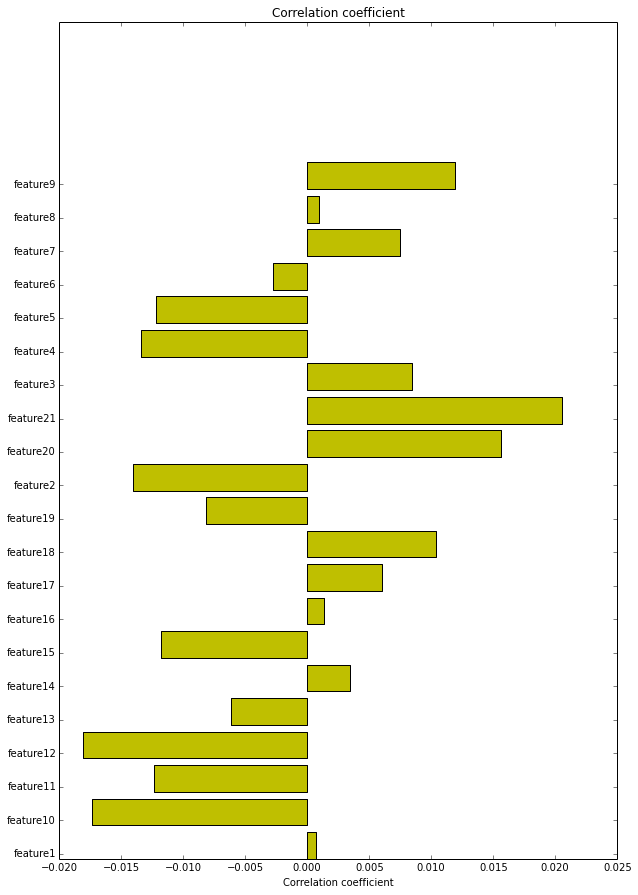

In [6]:
# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in X.columns]

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(training_data[col].values, training_data['target'].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.3
fig, ax = plt.subplots(figsize=(10,15))
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()

As expected, the correlation coefficient values are very low and the maximum value is around 0.022 (in positive) as seen from the plot above.

Let us take the top 4 variables from the plot above and do some more analysis on them alone.

 - feature2
 - feature10
 - feature12
 - feature21

As a first step, let us get the correlation coefficient in between these variables. 

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


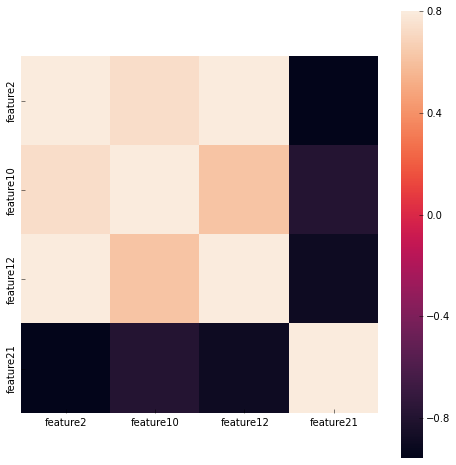

In [7]:
cols_to_use = ['feature2', 'feature10', 'feature12', 'feature21']

temp_df = training_data[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [8]:
X.fillna(0, inplace=True)

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [9]:
#*** Split into training and testing data
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
X_train.sort_index(axis=1, inplace=True)
X_test.sort_index(axis=1,inplace=True)
X_val.sort_index(axis=1,inplace=True)
print (len(X_train))
print (len(X_val))
print (len(X_test))

86724
21681
45638


In [10]:
unique, counts = np.unique(y_train, return_counts=True)
print unique
print counts
dict(zip(unique, counts))

[0 1]
[43020 43704]


{0: 43020, 1: 43704}

In [11]:
from xgboost import XGBClassifier
model = XGBClassifier() 
model.fit(X_train, y_train)

#scores = cross_val_score(model, X, y, cv=5)
#print (scores.mean())

#*** Test
y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

#*** Get Accuracy
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_val, y_val_pred)
train_acc = accuracy_score(y_train, y_train_pred)
print ('Train accuracy: ', train_acc)
print ('Test accuracy: ', test_acc)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('Train accuracy: ', 0.5415455929154559)
('Test accuracy: ', 0.51648909183155756)


In [12]:
print("Predicting...")
# Your trained model is now used to make predictions on the numerai_tournament_data
# The model returns two columns: [probability of 0, probability of 1]
# We are just interested in the probability that the target is 1.
y_test_pred = model.predict_proba(X_test)
results = y_test_pred[:, 1]
results_df = pd.DataFrame(data={'probability':results})
joined = pd.DataFrame(ids).join(results_df)

Predicting...


In [13]:
# save the classifier
stats = {"train accuracy": train_acc,"test accuracy":test_acc, 'label':'initial model',}
# Save the predictions out to a CSV file
predictions_path = os.path.join(os.environ['OUTPUT_DIR'], 'predictions.csv')
joined.to_csv(predictions_path, index=False)
model_filename = os.path.join(os.environ['OUTPUT_DIR'],'model.dat')
pickle.dump(model, open(model_filename, 'wb'))
stats_filename = os.path.join(os.environ['OUTPUT_DIR'],'stats.json')
with open(stats_filename, 'wb') as f:
    f.write(json.dumps(stats))

In [14]:
#scores

In [15]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 43020, 1: 43704}

In [16]:
unique, counts = np.unique(y_val, return_counts=True)
dict(zip(unique, counts))

{0: 10729, 1: 10952}

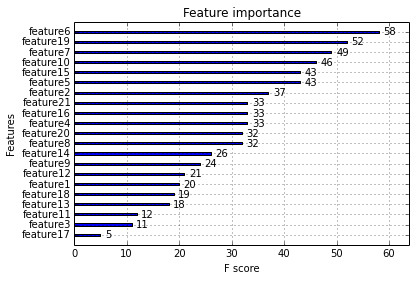

In [17]:
import xgboost as xgb
xgb.plot_importance(model)